# Flux measurements training SFERA-III STT16
Anita Haeussler, PROMES Laboratory

![](https://user-images.githubusercontent.com/102672251/273207866-dcb95a2f-e0ce-4be5-98be-cffc38b9d398.png)
![promes_haute_resolution](https://user-images.githubusercontent.com/102672251/273208814-195fb560-b728-41a4-9fca-87c122d2ae3e.jpg)
![cnrs](https://user-images.githubusercontent.com/102672251/273209781-d2635dca-5fa4-4ec4-be24-85547c09adbb.png)

# Before starting
All the data required to run this code can be dowloaded from this link :
https://mycore.core-cloud.net/index.php/s/1YQjkBQPqHzgf2E

And add the path of this folder in variable `FOLDER_PATH` in  `general_functions.ipynb` (part Constances)

# Principle
The following code details the different steps to obtain a solar flux distribution map. Those one are summarized below.


![schema_general_fluxmetry](https://user-images.githubusercontent.com/102672251/273208637-9a31af6a-92b1-420c-85f3-0ea8279b7493.png)

In order to produce a solar flux distribution map for the small solar facilities at the PROMES laboratory, we used the device shown below. A crane (non-represented here) allows to deplace the target in different planes.
![](https://user-images.githubusercontent.com/102672251/273208151-f3748043-5a34-4835-b40a-8af5768b10a9.png)




# Package
All the packages used here are defined below.

In [5]:
# System interphase
import os
# Images management
import cv2
# Matrice management
import numpy as np
# Graphic
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar 
# To import (homemade) jupyter Notebooks
import import_ipynb

## Homemade notebooks
import general_functions as functions
import radiometric_calibration
import Spatial_calibration

# Obtain a raw image

## Repertory path
Here, the repertory where the images are stored, is defined.

In [6]:
parent_path = os.path.join(functions.FOLDER_PATH, "flux_map")

## Parameters of the camera
`PETALE2` software has been developed at the PROMES laboratory to acquire a number of images from the camera at maximum speed, with the date and time of each image. For each series of images, the `PETALE2` software creates a log file in which the camera parameters used are stored, along with the date and time of each image. 

In [7]:
# Get the name of the log file
log_name = [log for log in os.listdir(parent_path) if log.endswith(".txt")][0]
# Get the log path
log_path = os.path.join(parent_path, log_name)
parameters = functions.get_img_parameters(log_path)
print(parameters)

{'Date': '2022-05-13', 'Time': '11-55-42', 'ExposureValue': 7000.0, 'GainValue': 0.0, 'Gamma': 1.0, 'WhitebalValueRed': 120.0, 'WhitebalValueBlue': 224.0, 'OffsetValue': 0.0, 'TimeStampFrequency': 48000000.0, 'CameraName': 'SISIA 4 - V2', 'DeviceModelName': 'Manta_G-125C', 'DeviceSerialNumber': '50-0503328886'}


## Read the initial images
For each cartography, 100 images are taken by the camera, to limit digital noise.

In [8]:
img_names = [name for name in os.listdir(parent_path)
             if name.endswith(".tiff")]
imgs = np.empty((len(img_names), 964, 1292), np.float64)
for idx, img_name in enumerate(img_names):
    img_path = os.path.join(parent_path, img_name)
    # Read image
    img = cv2.imread(img_path, -1)
    # Split images in RGB channels
    img = cv2.split(img)
    # Keep the red channel
    img = img[0]
    # Store images
    imgs[idx, :, :] = img

## DNI normalization
In order to be able to compare different flux distribution maps, they must be normalized according to Direct Normal Irradiation (DNI). Historically, a value of 1000 W/m² has been used, corresponding to 1 sun.

In [9]:
for idx, img_name in enumerate(img_names):
    ## Acquisition time
    img_time = [img_name[29:31],  # hour
                img_name[31:33],  # minute
                img_name[33:39]]  # second
    # DNI at the instant of the image
    img_DNI = functions.get_DNI(parameters["Date"], img_time)
    img  = imgs[idx, :, :]
    img = img * functions.NORM_DNI / img_DNI
    imgs[idx, :, :] = img

# Build the raw image
From the 100 images taken, one image is built.

## Mean method
For each pixel, its value is obtained by averaging the values of the corresponding pixels in the initial image set

In [10]:
img_mean = np.mean(imgs, axis=0)

## Median method
For each pixel, its value is obtained by the median of the values of the corresponding pixels in the initial image set

In [11]:
img_med = np.median(imgs, axis=0)

## Median of Means method
This method consists in calculating the median of pixel values from a set of images, then taking the average of pixel values in a neighborhood of the median, can be used to create a composite image that combines the advantages of the median and the average.

In [12]:
nb_img = len(imgs)
nb_pix = 10
orded_imgs = np.sort(imgs, axis=0,
                 kind="quicksort", order=None)
orded_imgs = orded_imgs[(nb_img-nb_pix)//2:
                    (nb_img+nb_pix)//2, :, :]
img_med_mean = np.mean(orded_imgs, axis=0)

raw_img = img_med_mean

## Display 

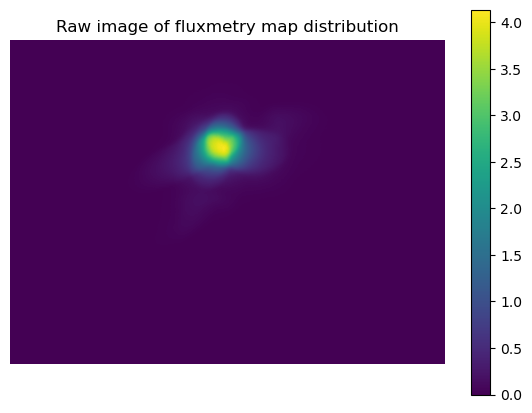

In [13]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
plt.title("Raw image of fluxmetry map distribution")
plt.imshow(raw_img/1e3)
plt.axis("off")
plt.colorbar()
plt.show()

# Image calibrations
The raw image previously obtained does not contain any quantitative information, as the image is neither radiometric nor spatially calibrated. Then these two calibrations are required.

## Spatial calibration
The spatial calibration requires to obtain the size of one pixel. Possibly resize the image so that the pixel size is a round count.

In [14]:
# Pixel size before spatial calibration
init_pix_size = Spatial_calibration.pix_size
print(init_pix_size)
# Pixel size after spatial calibration
new_pix_size = 5e-5
# Pixel ration between before and after spatial calibration
size_ratio = new_pix_size/init_pix_size
# Intial size of the image
nb_pixel_y, nb_pixel_x = raw_img.shape
# Image resizing for each pixel size correspond to new_pixel size
resized_img = cv2.resize(raw_img, 
                          dsize = (int(nb_pixel_x*size_ratio), int(nb_pixel_y*size_ratio)),
                          interpolation=cv2.INTER_CUBIC)

# New size of the image
nb_pixel_Y, nb_pixel_X = resized_img.shape

# The image is resize in order to keep the initial image size
# If the resized image has been shrunk
if nb_pixel_x > nb_pixel_X: 
    # Add pixel egal to 0 on the size
    new_img = np.zeros((964, 1292), np.float64)
    new_img[int((nb_pixel_y-nb_pixel_Y)/2):int((nb_pixel_y-nb_pixel_Y)/2)+nb_pixel_Y,
                int((nb_pixel_x-nb_pixel_X)/2):int((nb_pixel_x-nb_pixel_X)/2)+nb_pixel_X] = resized_img
# If the resized image has been enlarged
elif nb_pixel_x < nb_pixel_X:
    # the image is cropped at the edges
    new_img = resized_img[int((nb_pixel_Y-nb_pixel_y)/2):int((nb_pixel_Y-nb_pixel_y)/2)+nb_pixel_y,
                int((nb_pixel_X-nb_pixel_x)/2):int((nb_pixel_X-nb_pixel_x)/2)+nb_pixel_x]

img_spatial_calib = new_img

5.920368434868592e-05


## Display

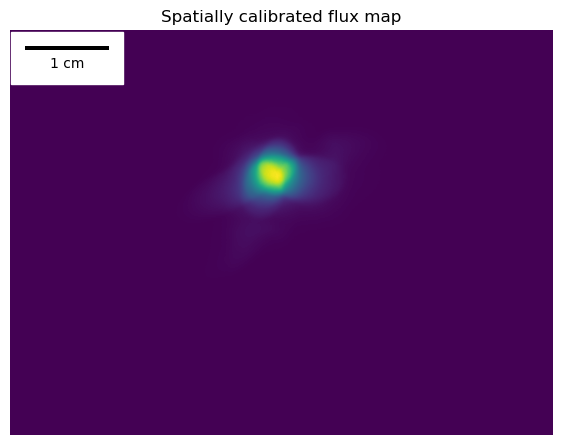

In [15]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
plt.imshow(img_spatial_calib)
plt.axis("off")
plt.title("Spatially calibrated flux map")
# plt.colorbar(label="Grey levels", shrink=0.5)
scalebar = ScaleBar(new_pix_size, "m",
                    length_fraction=0.25,
                    location="upper left",
                    pad=1)
ax.add_artist(scalebar)

plt.show()

## Radiometric calibration
The radiometric calibration consists in converting the value of all the pixels from grey levels to power density. The correspond between grey levels to power density is calculated in the `radiometric_calibration` file

In [19]:
GL2density_factor = radiometric_calibration.GL2density_factor
flux_map = img_spatial_calib * GL2density_factor

## Display

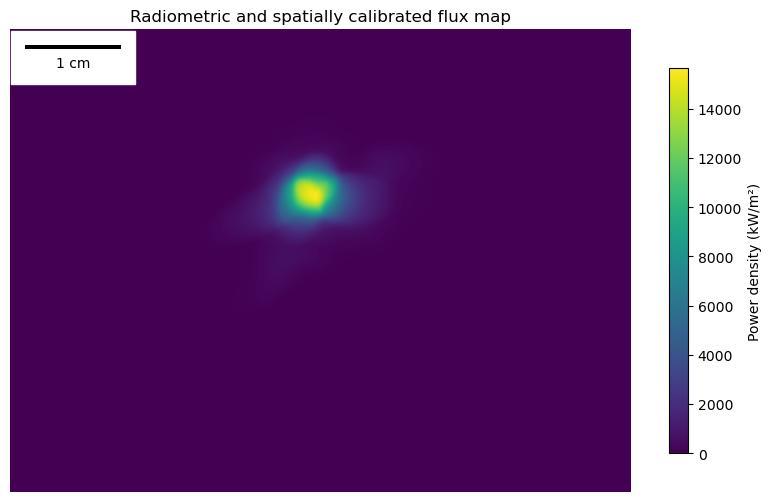

In [20]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.imshow(flux_map/1e3)
plt.axis("off")
plt.title("Radiometric and spatially calibrated flux map")
plt.colorbar(label="Power density (kW/m²)", shrink=0.5)
scalebar = ScaleBar(new_pix_size, "m",
                    length_fraction=0.25,
                    location="upper left",
                    pad=1)
ax.add_artist(scalebar)
plt.show()

# How to represent this flux distribution map ?

With Flux map with contours

![flux_map](https://user-images.githubusercontent.com/102672251/273209049-fe40b625-edde-421d-95f6-48501ba6dce9.png)

Evolution of the maximal intensity with elevation

![intensity_vs_elevation](https://user-images.githubusercontent.com/102672251/273208905-0780494b-d17d-4308-aa64-f1321debcde1.png)


The evolution of the barycenter with elevation 

![barycenter](https://user-images.githubusercontent.com/102672251/273209441-233f2591-a429-4b61-ba2f-7b07c92f4646.png)

Represents the focal spot depending on the elevation 

![focal_vs_elevation](https://user-images.githubusercontent.com/102672251/273208997-36d6ca1c-e005-467b-86d0-779bf76c7e68.png)

It is also possible to determine the angle of the parabola axis.

![angles_axes](https://user-images.githubusercontent.com/102672251/273209498-5dacd147-6d72-4412-a190-17e399657c63.png)

In [ ]:

clabel_color = "whitesmoke"

flux_map = flux_map / 10**3
CM = 1/2.54  # (CM) centimeters in inches
FIGSIZE = (11.6*CM, 14.8*CM)
fig_trace_complet = plt.figure(figsize=(16*CM, 16*CM), dpi=110)
histo_moy_x = np.mean(flux_map, axis=0)
histo_moy_y = np.mean(flux_map, axis=1)

histo_max_x = np.max(flux_map, axis=0)
histo_max_y = np.max(flux_map, axis=1)

histo_moy_x_max = histo_moy_x.max()
histo_moy_y_max = histo_moy_y.max()

histo_max_x_max = histo_max_x.max()
histo_max_y_max = histo_max_y.max()

histo_x = np.zeros((1, 
                    flux_map.shape[0]), 
                   np.float64)  # Moyenne selon l'axe X
histo_y = np.zeros((1,
                    flux_map.shape[1]), 
                   np.float64)  # Moyenne selon l'axe Y


    # no labels
nullfmt = plt.NullFormatter()
size_y, size_x = flux_map.shape
# definitions for the axes
left, width = 0.1, 0.5
bottom, height = 0.1, width * size_y/size_x

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + 0.02, width, 0.21]
rect_histy = [left + width + 0.02, bottom, 0.21, height]
rect_cbar =  [left+width+0.25, bottom, 0.01, height]

# start with a rectangular Figure
# plt.figure(1, figsize=(8,8))

axHistxy = plt.axes(rect_scatter)
xlist = np.linspace(0, flux_map.shape[1], flux_map.shape[1])
ylist = np.linspace(0, flux_map.shape[0], flux_map.shape[0])
X, Y = np.meshgrid(xlist, ylist)

(mini, maxi, minLoc, maxLoc) = cv2.minMaxLoc(flux_map)
levels_nb = 5
magn_order = int(math.log10(maxi))-1
level_first = int(maxi/(levels_nb*10**magn_order)) *10**magn_order
level_step = level_first
level_max = int(maxi/10**magn_order)*10**magn_order
levels = range(level_first,
               level_max,
               level_step)
flux_map_simply = flux_map.copy()
kernel = np.ones((5,5),np.uint8)
flux_map_simply = cv2.morphologyEx(flux_map_simply, cv2.MORPH_OPEN, kernel)
flux_map_simply = cv2.morphologyEx(flux_map_simply, cv2.MORPH_CLOSE, kernel)
cp = plt.contour(flux_map_simply, cmap="afmhot", linestyles='dashed', levels=levels, linewidths=1)
plt.clabel(cp, inline=True, fontsize=10,  inline_spacing=5, use_clabeltext=True)

axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
axCbar = plt.axes(rect_cbar)

#     # no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistxy.set_xlabel("Axis x (pixel)")
axHistxy.set_ylabel("Axis y (pixel)")

#     # cartographie
carto = axHistxy.imshow(flux_map, cmap= 'afmhot_r', vmin = 0)  # image cartographie
axHistxy.hlines(maxLoc[1], 0, 1291, linestyles='dashed', colors='#000000', linewidth = 1.2)  # trait horizontal sur le centre
axHistxy.vlines(maxLoc[0], 0, 963, linestyles='dashed', colors='#000000', linewidth = 1.2)  # trait vertical sur le centre
plt.colorbar(carto, cax=axCbar, label="Suns")
# compas = Fluxmetrie_fonctions.get_compas_img()
# axHistxy.add_artist(compas)
scalebar_ = ScaleBar(new_pix_size, "cm",
                    length_fraction=0.1,
                              border_pad=0.15,
                    location="upper left",
                    pad=1)
axHistxy.add_artist(scalebar_)

# plot x hist
histo_x = np.mean(flux_map, axis=1)
axHistx.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')
axHistx.plot(histo_moy_x, '-', color ='darkorange', label="moyenne")
axHistx.plot(histo_max_x, '-', color ='saddlebrown', label="maximum")
axHistx.set_ylabel("Suns")
axHistx.vlines(maxLoc[0], 0, (histo_max_x).max(),
               linestyles='dashed', colors='#000000',
               linewidth = 1.2)  # trait vertical sur le centre
# plot y hist
histo_y = np.mean(flux_map, axis=0)
axHisty.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')   
axHisty.plot(histo_moy_y, np.linspace(0, 964, 964), color='darkorange', label="moyenne")
axHisty.plot(histo_max_y, np.linspace(0, 964, 964), color='saddlebrown', label="maximum")
axHisty.set_xlabel("Suns")
axHisty.hlines(maxLoc[1], 0, (histo_max_y).max(), linestyles='dashed', color ='#000000', linewidth = 1.2)  # trait horizontal sur le centre

axHistxy.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')

# Set Limits pour les histo
axHistx.set_xlim(axHistxy.get_xlim())
axHisty.set_ylim(axHistxy.get_ylim())
axHistx.set_ylim(ymin=0)
axHisty.set_xlim(xmin=0) 

axHistx.legend()
axHisty.legend()

# cs = plt.contourf(h, levels=[10, 30, 50],
#     colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')


figname = f"Carto_{open_shutter}%.tiff"
plt.savefig(figname, dpi=300)
plt.show()